In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Import libraries
import numpy as np
from scipy import integrate
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt 
import matplotlib.cm as cm # colormaps
import matplotlib.colors as colors
import astropy.io.fits as pyfits
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

import pandas as pd
import math 
from astropy.table import Table
from astropy.io import ascii
from astropy.wcs import WCS


from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc

import FITS_tools #https://github.com/keflavich/FITS_tools/tree/master/FITS_tools
from reproject import reproject_interp

In [5]:
##Calculate the opacity by interpolating from Ossenkopf (1994)
##thin ice mantles that have undergone coagulation for 10^5 years at a density of ∼ 10^6 cm−3
##Eqn 6##
#k0, k11, k13 are the mass absorption coeffs in cm2/g for gas densities at the initial distribution, 10^6, and 10^8 
#as described in table 1, for each wavelength you want to consider

def LOG_opacity(v, k0, k11, k13):
    nH = 10**6
    t_coag = 10**5
    
    a = (1./2) * (np.log10(k0)**2 - 4*(np.log10(k11)**2) + 3*(np.log10(k13)**2)) \
                  /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                    
    b = (1./4) * ((np.log10(k13)-np.log10(k11))*(np.log10(k13)-np.log10(k0))*(np.log10(k11)-np.log10(k0)))\
                    /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                      
    lgk = a - np.sqrt( (a-np.log10(k13))**2 + b*(np.log10(nH*t_coag)-13)**2  )
    
    return v, lgk


In [6]:
##Calculate lgk for wavelengths in the table around what you want to find. 
#Then use scipy.interpolate 

#Read in the txt files
v_um, k0 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_initdist.txt').T
v_um, k11 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_106cm-3.txt').T
v_um, k13 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_108cm-3.txt').T

v_um, log_k = LOG_opacity(v_um, k0,k11,k13)


logk_interp = interpolate.interp1d(v_um, log_k)

# Herschel 70um calculations

In [11]:
#Feb 27th, 2023 Redid all the dumb geometry that was previously done Feb 27th, 2009...
#GAH! Law of cosines!

#Distribution of stars proportional to e^-(R/h_{R})
def disk_dist(d, n0, l):
    R_sun = 8.4 #kpc
    h_R = 3.5 #Galactic radial scale in kpc
    R = np.sqrt(d**2 + R_sun**2 -(2*d*R_sun*np.cos(np.deg2rad(l))))    

    return n0 * np.exp(-R/h_R)##Function to automate 70um fits##

#define extinction surface density function
#f_fore is the fraction of LOS emission from foreground
#I_0_obs is intensity behind cloud
#I_1_obs is intensity in front of cloud
def Sigma_70um(f_fore, I_0_obs, I_1_obs):
    k_v = 1.74 #cm^2/g #dust opacity for 70um
    return (-1./k_v) * np.log(  (I_1_obs - (f_fore*I_0_obs)) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


#If the front of cloud intensity is much larger than the assumed background, the log() will be positive
#And the sigma will come out negative

#Will return nans if doing log of negative number (i.e. if the background is MUCH higher than the front of
#the cloud)

In [12]:
#Convert to col den = (Sigma/mu*m_H)
def N(sig):
    mu = 2.8
    m_H = 1.67e-24 #g
    return sig/(mu*m_H)


#70um extinction column density calculation 
def cloud_extinction_calc_70um(hers, f_fore, smoothed, obs):
    #Create list to populate 
    Sigma = np.zeros(shape=(len(hers),len(hers[0])))
    ext_N = np.zeros(shape=(len(hers),len(hers[0])))
    
    #For-loop for 2D array, first y then x
    for i in np.arange(len(hers)):

        for j in np.arange(len(hers[0])):
            if smoothed[i][j] == np.NaN:
                Sigma[i][j] = np.NaN
                ext_N[i][j] = np.NaN

            else:
                sig = Sigma_70um(f_fore, smoothed[i][j], obs[i][j])
                Sigma[i][j] = sig
                ext_N[i][j] = N(sig)
                
    return ext_N


#optical depth conversion for later plotting
def tau_nu(NH2,k_v):
    mu = 2.8
    m_H = 1.67e-24 #g
    return k_v * (NH2*mu*m_H)


# 70um ExtN Calculation and plots!

In [13]:
## Function to calculate extinction and create ext vs emission plots
## This function uses the individual cloud cutouts for with 70um sources removed


def cloud_EmvsExt_NANS_and_SUB(cloud, f_fore):


    #Herscehl 70um
    cloud_herschel_regrid_fits = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_70um.fits'.format(cloud, cloud))

    cloud_70um_fits = pyfits.open('./Cloud_masks/{}/{}_herschel70um_cutout_isolated.fits'.format(cloud, cloud))
    cloud_70um_smoothed_fits = pyfits.open('./Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud, cloud))

    cloud_70um_tonans_fits = pyfits.open('./Cloud_masks/{}/{}_herschel70um_sources_to_nans_cutout_isolated.fits'.format(cloud, cloud))
    
    # copy the FITS data into a numpy array
    cloud_70um = cloud_70um_fits[0].data
    cloud_70um_smoothed = cloud_70um_smoothed_fits[0].data
    cloud_hers_regrid_70 = cloud_herschel_regrid_fits[0].data
    
    cloud_70um_tonans = cloud_70um_tonans_fits[0].data



    h_cloud_70um = pyfits.getheader('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_70um.fits'.format(cloud, cloud))

    #Get the avg column density from herschel
    cloud_avg_hers= np.nanmean(cloud_hers_regrid_70) #finds average ignoring nans

    #Calculate a 2D array for the whole cloud#
    cloud_ext_N_nans = cloud_extinction_calc_70um(cloud_hers_regrid_70, f_fore, cloud_70um_smoothed, cloud_70um_tonans)




    pyfits.writeto('./Cloud_masks/{}/{}_70umExtN_ffore{:.2f}_tonans.fits'.format(cloud, cloud, f_fore), cloud_ext_N_nans, h_cloud_70um, overwrite=True)


    
    return 




# Convolve and Regrid Step

In [14]:
cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049","G1.601+0.012", "G1.652-0.052"  ]


f_fore_list=np.linspace(0.2,0.4,14)
#f_fore_list=[0.5]

cloud_list = ["G0.255+0.02"]
#f_fore_list=[0.3,0.4,0.45,0.5]

#Make your Gaussian
# sigma_gauss = sqrt( resolution you want^2 - resolution you have^2) = gaussian sigma
# gaussian sigma / number of arcseconds per pixel = 2 pixels # Your number will be different

#Want to match 36" convolution, hers 70um resolution is 6"
higal_colden_res = 36 /2.355 #sigma = FWHM/sqrt(8ln2) = FWHM/2.355
highal70_res = 6/2.355

sig_gauss = np.sqrt(higal_colden_res**2 - highal70_res**2 )
kern = sig_gauss/(3.2) #arcsec/pix

for Cloud in cloud_list:

    for f_fore in f_fore_list:
        cloud_EmvsExt_NANS_and_SUB(Cloud, f_fore) #calculate Ext Col Den 


        nans_sub_file = './Cloud_masks/{}/{}_70umExtN_ffore{:.2f}_tonans.fits'.format(Cloud, Cloud,f_fore)
        nans_sub_data = pyfits.open(nans_sub_file)[0].data

        hers70um = './FITS/destripe_l000_blue_wgls_rcal_cropped.fits'


        #h_fpeak = pyfits.getheader(fpeak_sub_file)
        h_nans = pyfits.getheader(nans_sub_file)
        h_hers70 = pyfits.getheader(hers70um)

    
        smoothed_nans = convolve_fft(nans_sub_data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

        #Write to FITS
        pyfits.writeto('./Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud,Cloud, f_fore), smoothed_nans, h_nans, overwrite=True) 
        
        
        
        
        
        ###REGRIDDING####
        
        #Load in the convolved file
        conv_file = pyfits.open('./Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud,Cloud, f_fore))[0]
        
        
        #load in the cutout herschel file we want to regrid to
        cloud_hers_cutout = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud, Cloud))[0]
        
        regrid_array, regrid_footprint = reproject_interp(conv_file, cloud_hers_cutout.header)
        
        
        pyfits.writeto('./Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, f_fore), 
                   regrid_array, cloud_hers_cutout.header, overwrite=True)       


In [15]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.arange(-1,30)
    y_vals = intercept + slope * x_vals
    return x_vals, y_vals
    


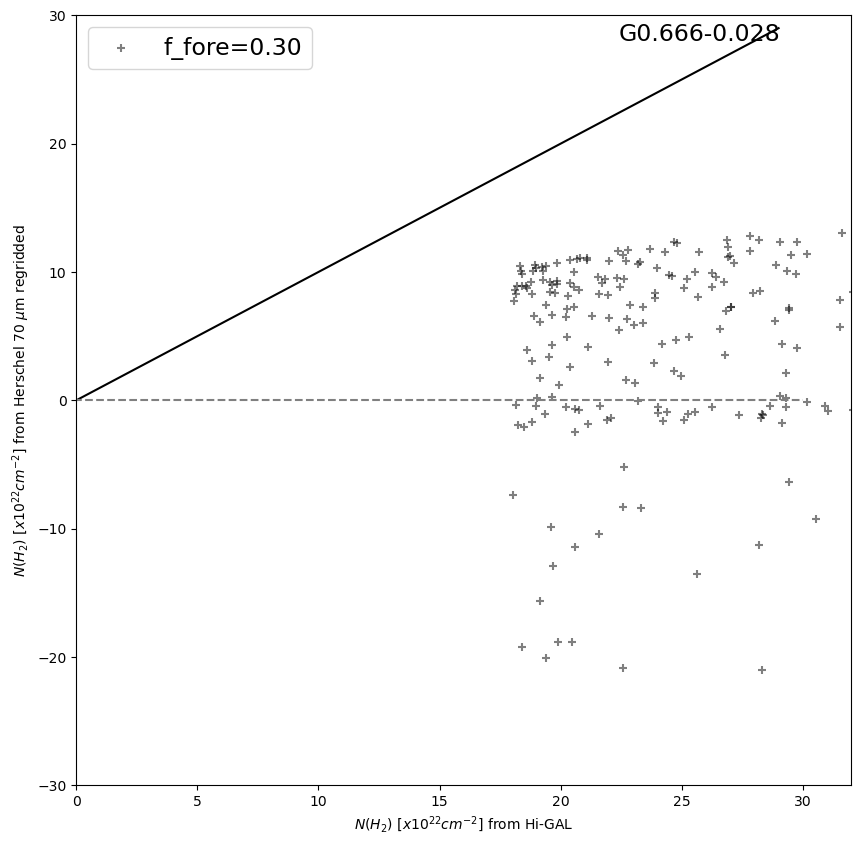

corr of optically thin points:  -0.28848471783675783
corr of all points:  -0.28848471783675783


In [16]:
cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049" ,"G1.601+0.012", "G1.652-0.052" ]



cloud_list = ["G0.666-0.028"]


ext_list_70_conv = []
em_list_70_conv = []


f_fore=0.3

#f_fore_list=[0.3,0.4,0.45,0.5]

for Cloud in cloud_list:

    
    regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, f_fore)

    regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

    cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud,Cloud)
    cloud_hers_data = pyfits.open(cloud_hers)[0].data
    
    wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)
    
    em_list_70_conv.append(np.nanmedian(cloud_hers_data)/10**22)
    ext_list_70_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)
    
    
    #Make plot similar to Fig 3 in Battersby 2010

    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot()
    plt.rcParams.update({'font.size': 17})

    x = np.arange(-1,30)
    y = np.arange(-1,30)
    x_vals, y_vals = abline(0, 3.5) 

    y_vals = np.arange(-5,30)
    x_vals = np.full(np.shape(y_vals),16)
    


    
    ###Find what points lie above/below a certain line###
    

    xp_list = np.zeros(np.shape(regrid_to_nans_data))
    
    
    
    for i in range(np.shape(regrid_to_nans_data)[0]):
        for j in range(np.shape(regrid_to_nans_data)[1]):
            xA = cloud_hers_data[i,j]/1E22
            yA = regrid_to_nans_data[i,j]/1E22

            v1 = (x_vals[-1]-x_vals[0], y_vals[-1]-y_vals[0])   # Vector 1
            v2 = (x_vals[-1]-xA, y_vals[-1]-yA)   # Vector 2
            xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product (magnitude)

            xp_list[i][j]=xp
            

    
    ax1.scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={:.2f}".format(f_fore))
    
    #ax1.scatter(cloud_hers_data[xp_list>0]/1E22,regrid_to_nans_data[xp_list>0]/1E22, 
    #            marker='+', color = 'r', alpha=0.5, )    


    
    plt.plot(x,y, c='black')
    #plt.plot(x_vals,y_vals, c='red')
    
    
    plt.hlines(0,-1, 30, linestyle='--', color='gray')
    #plt.hlines(12.3,-1, 30, linestyle='--', color='red', label = "70um tau=1")
    plt.ylim(-30,30)
    plt.xlim(0,32)
    plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
    plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")
    plt.legend(loc=2)
    plt.text(.70, .99, '{}'.format(Cloud), ha='left', va='top', transform=ax1.transAxes)

    plt.show()
    
    xy_thin = pd.DataFrame({'Herschel thin': cloud_hers_data.flatten(), 'Ext Col Den thin': regrid_to_nans_data.flatten()})

    
    print('corr of optically thin points: ', xy_thin['Herschel thin'].corr(xy_thin['Ext Col Den thin']))
    
    xy_all = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
    print('corr of all points: ',xy_all['Herschel'].corr(xy_all['Ext Col Den']))
    


# COMPARE CORR COEFF WITH NEW METHODS

In [12]:
###Make new .txt file will the corr_coeffs 


tab = Table.read("./paper_figs/Tables/CMZ_cat_flux_method_corr_coeff.tex")

tab['Cloud_name'] = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071", 
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003","G0.143-0.083", 
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049", "G1.601+0.012", "G1.652-0.052"  ]


#df.to_csv("./paper_figs/Tables/CMZ_cat_flux_method_corr_coeff.tex", sep='\t', index = False)
 

In [13]:
corr_coeff_f05_thin_p = []
corr_coeff_f05_all_p = []
corr_coeff_f05_thin_s = []
corr_coeff_f05_all_s = []


ext_list_70_conv = []
em_list_70_conv = []

cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049" ,"G1.601+0.012", "G1.652-0.052" ]

cloud_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]



for Cloud in cloud_list:
    

    #ffore = 0.5
    regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, 0.50)
    regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

    cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud,Cloud)
    cloud_hers_data = pyfits.open(cloud_hers)[0].data
    
    wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)
    

    
    xy_all_p = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
    corr_coeff_f05_all_p.append(xy_all_p['Herschel'].corr(xy_all_p['Ext Col Den'], method='pearson'))


    xy_all_s = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
    corr_coeff_f05_all_s.append(xy_all_s['Herschel'].corr(xy_all_s['Ext Col Den'], method='spearman'))

        
corr_coeff_table = Table([cloud_ids, cloud_list, corr_coeff_f05_all_p, corr_coeff_f05_all_s], 
                         names = ('coeff_leaf_ids', 'cloud_list', 'p_f05_all','p_f05_all_spearman'))


d = {'coeff leaf ids':cloud_ids, 
     'cloud list':cloud_list, 
     'p f05 all':corr_coeff_f05_all_p,
     'p f05 all spearman':corr_coeff_f05_all_s}
df = pd.DataFrame(data=d)

df.to_latex('corr_coeff_table.tex',index=False, float_format='%.3f')

corr_coeff_table.round(decimals={'p_f05_all_spearman':3, 'p_f05_all':3 })
corr_coeff_table.write('corr_coeff_table.dat', format='ascii', overwrite=True)


#corr_coeff_table['coeff_leaf_ids','cloud_list', 'p_f05_all','p_f05_all_spearman'].pprint_all()

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24476/4232425969.py:53: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('corr_coeff_table.tex',index=False, float_format='%.3f')


In [25]:
def plot_six_panel_cloud(cloud):

    #example_8um=pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].data
    #wcs_8um = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_smoothed=pyfits.open('./Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_smoothed = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_70um=pyfits.open('./Cloud_masks/{}/{}_herschel70um_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_70um = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel70um_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_70um_masked=pyfits.open('./Cloud_masks/{}/{}_herschel70um_sources_to_nans_cutout_isolated.fits'.format(cloud, cloud))[0].data
    example_70um_ExtN=pyfits.open('./Cloud_masks/{}/{}_70umExtN_ffore0.50_tonans.fits'.format(cloud, cloud))[0].data
    example_70um_ExtN_conv_regrid = pyfits.open('./Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].data

    example_hershel = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_herschel = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    plt.rcParams.update({'font.size': 10})
    fig, ax = plt.subplots(2, 3, subplot_kw={'projection': wcs_70um}, figsize = (10,8), dpi = 300)
    ax[1,1].remove()
    ax[1,2].remove()
    ax_5 = fig.add_subplot(2,3,5, projection=wcs_herschel)
    ax_6 = fig.add_subplot(2,3,6, projection=wcs_herschel, sharex=ax_5, sharey=ax_5)
    
    #plt.subplots_adjust(wspace=0, hspace=0)

    
    
    mpl.rc('image', cmap='Blues_r')


    #match 70um and 70um masked colorscales 
    im_70um = ax[0,0].imshow(example_70um, cmap='bone')
    vmin_70um, vmax_70um = im_70um.get_clim()
    
    im_70um_masked = ax[0,1].imshow(example_70um_masked, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')
    
    
    im_70um_smoothed = ax[0,2].imshow(example_smoothed, vmin=vmin_70um, vmax=vmax_70um, cmap='bone')
    
    

    #match 70um Ext and 70um Ext Conv/Regrid colorscales 
    im_herschel = ax_6.imshow(example_hershel)
    vmin_hers, vmax_hers = im_herschel.get_clim()
    
    im_70um_ExtN = ax[1,0].imshow(example_70um_ExtN, vmin=vmin_hers, vmax=vmax_hers)
    vmin_70Ext, vmax_70Ext = im_70um_ExtN.get_clim()
    
    
    
    
    im_70um_ExtN_conv_regrid = ax_5.imshow(example_70um_ExtN_conv_regrid, vmin=vmin_hers, vmax=vmax_hers)


    print("peak N(H2) = {}".format(np.nanmax(example_hershel)) )
    
    
    
    
    ###BEAUTIFY PLOTS####    

    for i in range(2):
        for j in range(3):
            lon = ax[i,j].coords['glon']
            lat = ax[i,j].coords['glat']
            lon.set_ticks_visible(False)
            lon.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
            ax[i,j].set_facecolor('grey')
            
            
            
    #ax[0,0] and ax[1,0] can keep labels and ticks, the rest dont need them

    lon = ax[0,0].coords['glon']
    lat = ax[0,0].coords['glat']
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    
    ax[0,0].set_facecolor('gray')
    ax[0,0].set_xlabel('Galactic Longitude')
    ax[0,0].set_ylabel('Galactic Latitude')
    ax[0,0].set_facecolor('grey')


    lon = ax[1,0].coords['glon']
    lat = ax[1,0].coords['glat']
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    
    ax[1,0].set_facecolor('gray')
    ax[1,0].set_xlabel('Galactic Longitude')
    ax[1,0].set_ylabel('Galactic Latitude')
    ax[1,0].set_facecolor('grey')

    
    
    
    
    
    
    
    lon = ax_5.coords['glon']
    lat = ax_5.coords['glat']
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ax_5.set_facecolor('grey')

    lon = ax_6.coords['glon']
    lat = ax_6.coords['glat']
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ax_6.set_facecolor('grey')
    
    plt.tight_layout(w_pad = 0.5, h_pad=6)
    
    
    
    
    cb1 = fig.colorbar(im_70um, ax=ax[0,0], location='top',pad=0.0)
    cb2 = fig.colorbar(im_70um_masked, ax=ax[0,1], location='top',pad=0.0)
    cb3 = fig.colorbar(im_70um_smoothed, ax=ax[0,2], location='top',pad=0.0)
    cb4 = fig.colorbar(im_70um_ExtN, ax=ax[1,0], location='top',pad=0.0)
    cb5 = fig.colorbar(im_70um_ExtN_conv_regrid, ax=ax_5, location='top',pad=0.0)
    cb6 = fig.colorbar(im_herschel, ax=ax_6, location='top',pad=0.0)

    
    cb1.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
    cb2.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
    cb3.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.96, rotation=0, fontsize = 7)
    
    cb4.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)
    cb5.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)
    cb6.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.99, rotation=0, fontsize = 7)

    
    from string import ascii_lowercase as alc

    for m in range(len(fig.axes[6:])):
        fig.axes[m].text(0.07, 0.92,'({})'.format(alc[m]), ha='center', va='center', transform=fig.axes[m].transAxes)
    
    
       
    ax[0,0].text(0.82, 0.95,r'Herschel 70$\mu m$', ha='center', va='center', transform=ax[0,0].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)  
     
    ax[0,1].text(0.79, 0.92,'Herschel 70$\mu m$\nSources Removed', ha='center', va='center', transform=ax[0,1].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax[0,2].text(0.82, 0.92,'Herschel 70$\mu m$\nSmoothed', ha='center', va='center', transform=ax[0,2].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax[1,0].text(0.86, 0.95,r'70$\mu m$ ExtN', ha='center', va='center', transform=ax[1,0].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax_5.text(0.84, 0.92,"70$\mu m$ ExtN\nConv+Regrid", ha='center', va='center', transform=ax_5.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax_6.text(0.82, 0.95,r'Herschel N(H2)', ha='center', va='center', transform=ax_6.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)

    
    

    
    
    plt.savefig('./paper_figs/Figs/{}_six_panel.png'.format(cloud),bbox_inches='tight')


    plt.show()


peak N(H2) = 2.6784924596605402e+23


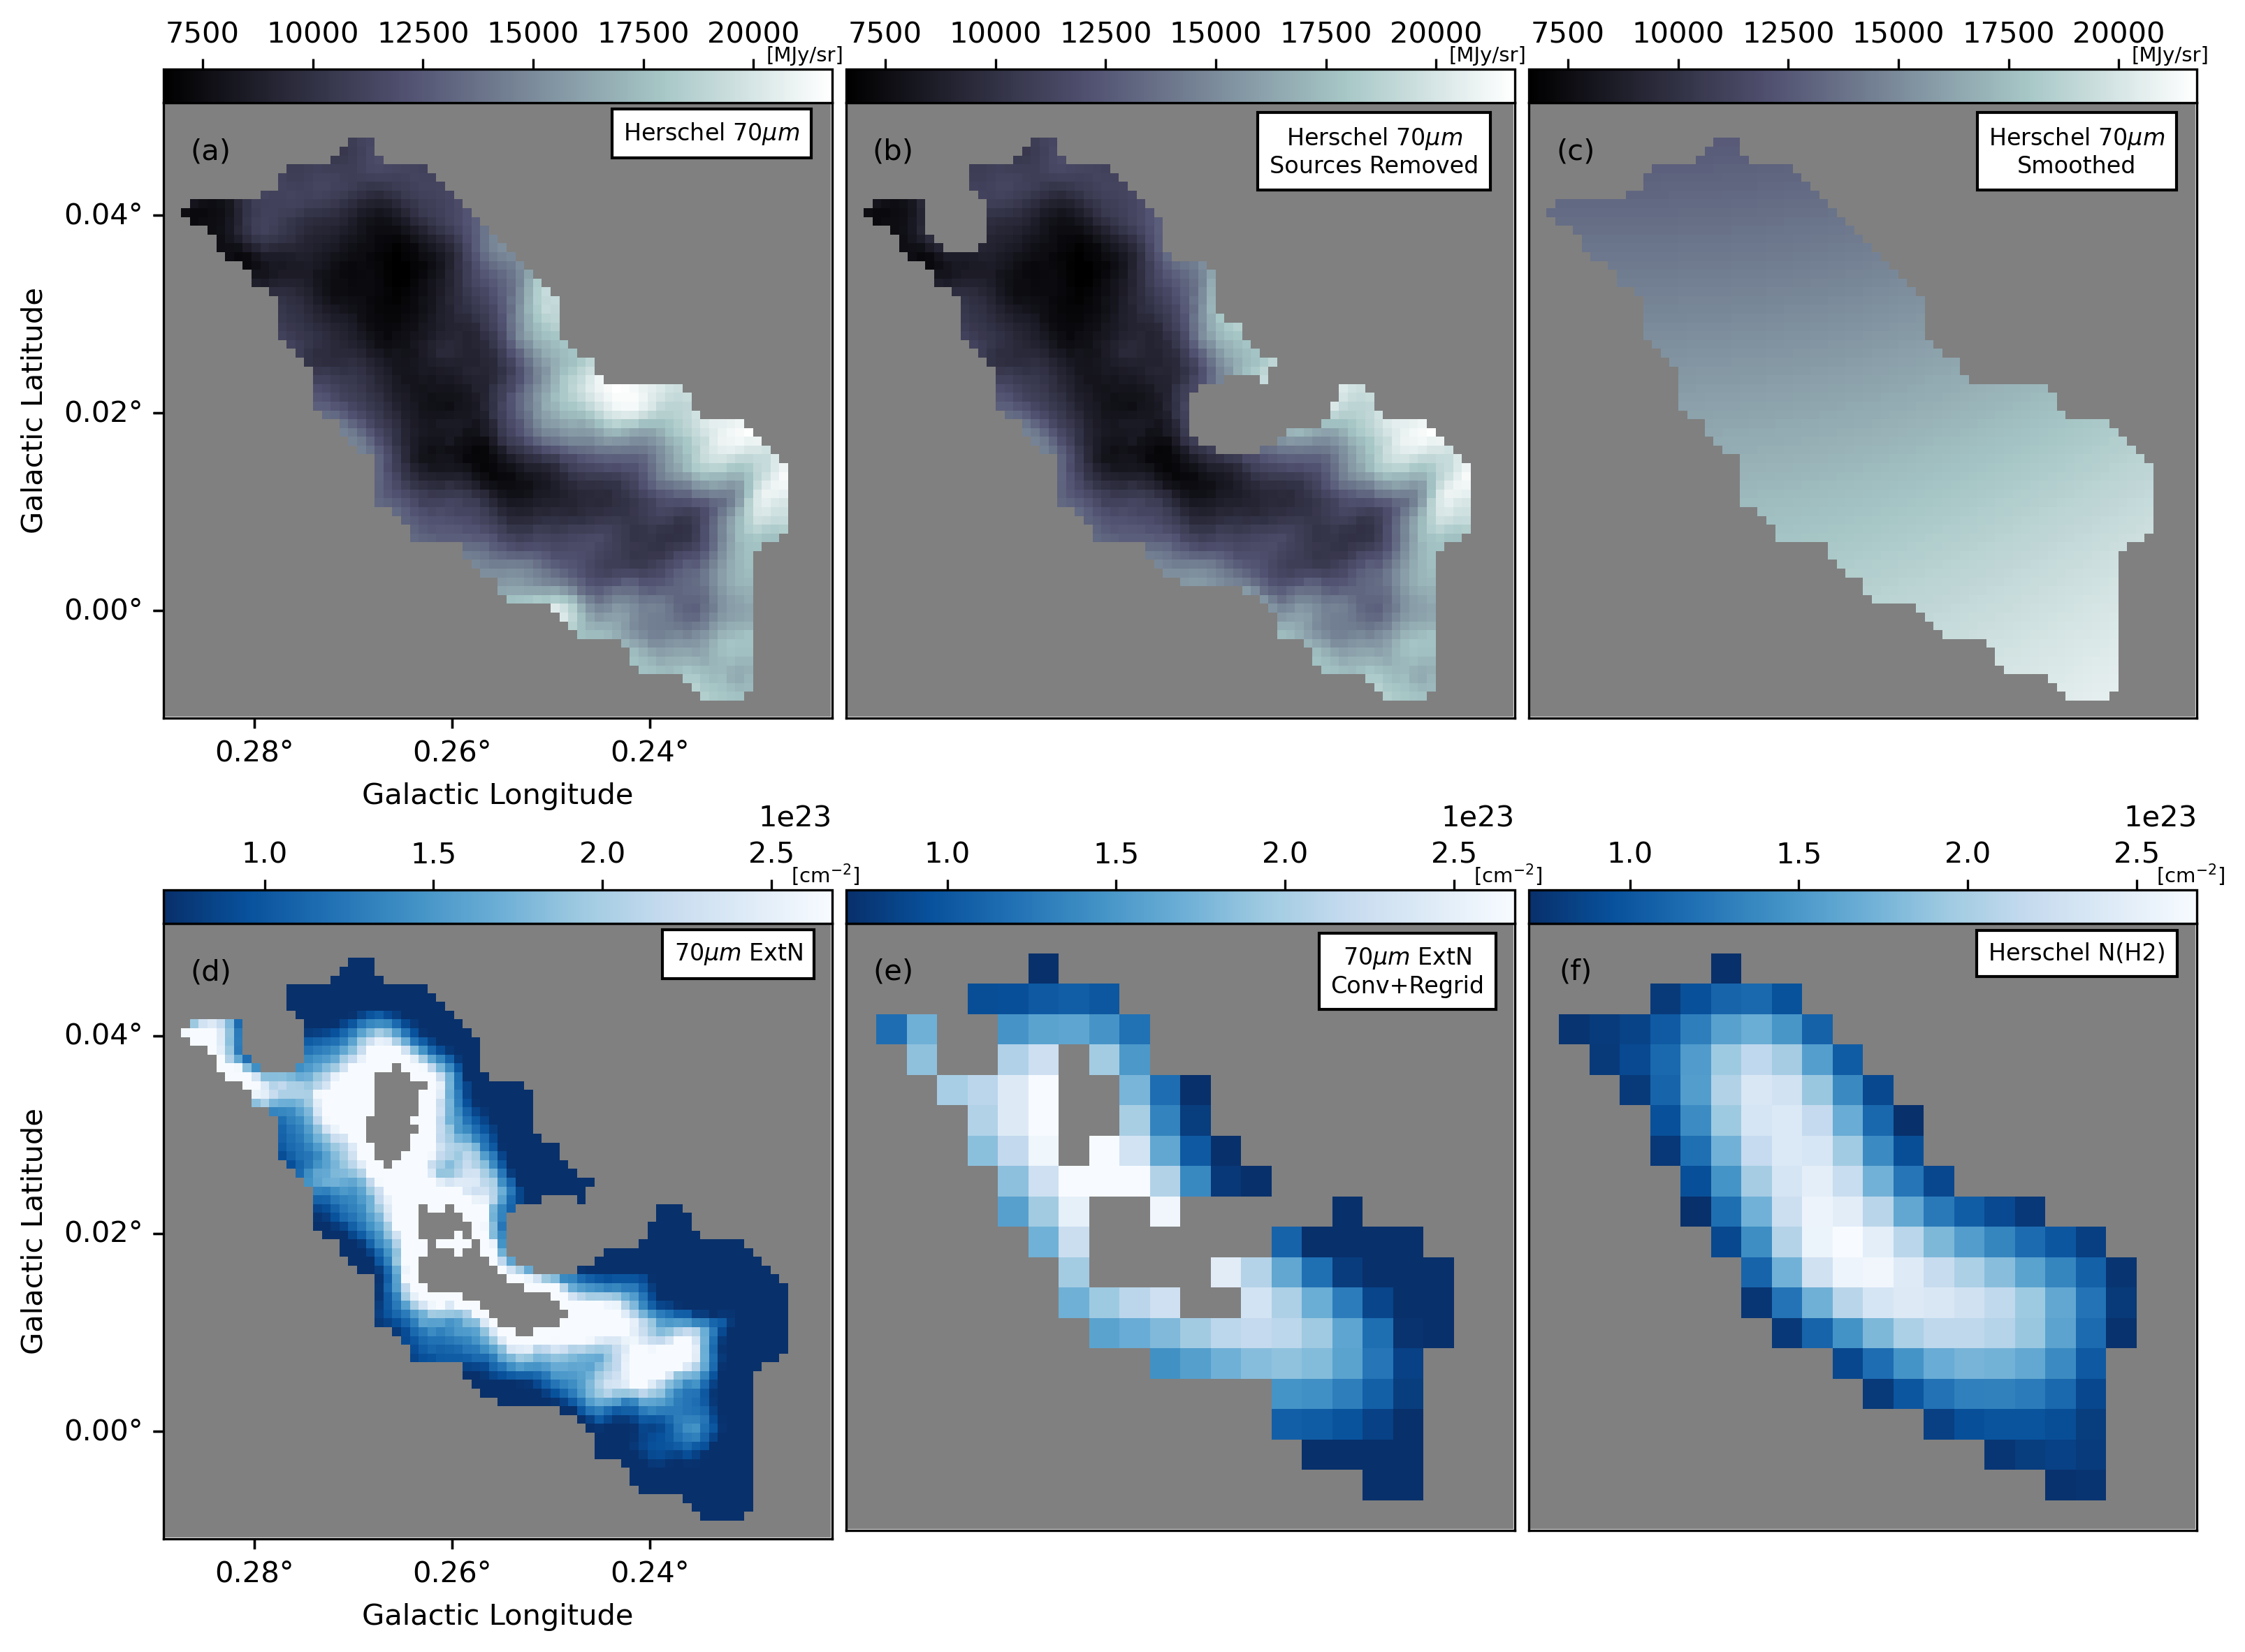

In [26]:
plot_six_panel_cloud("G0.255+0.02")

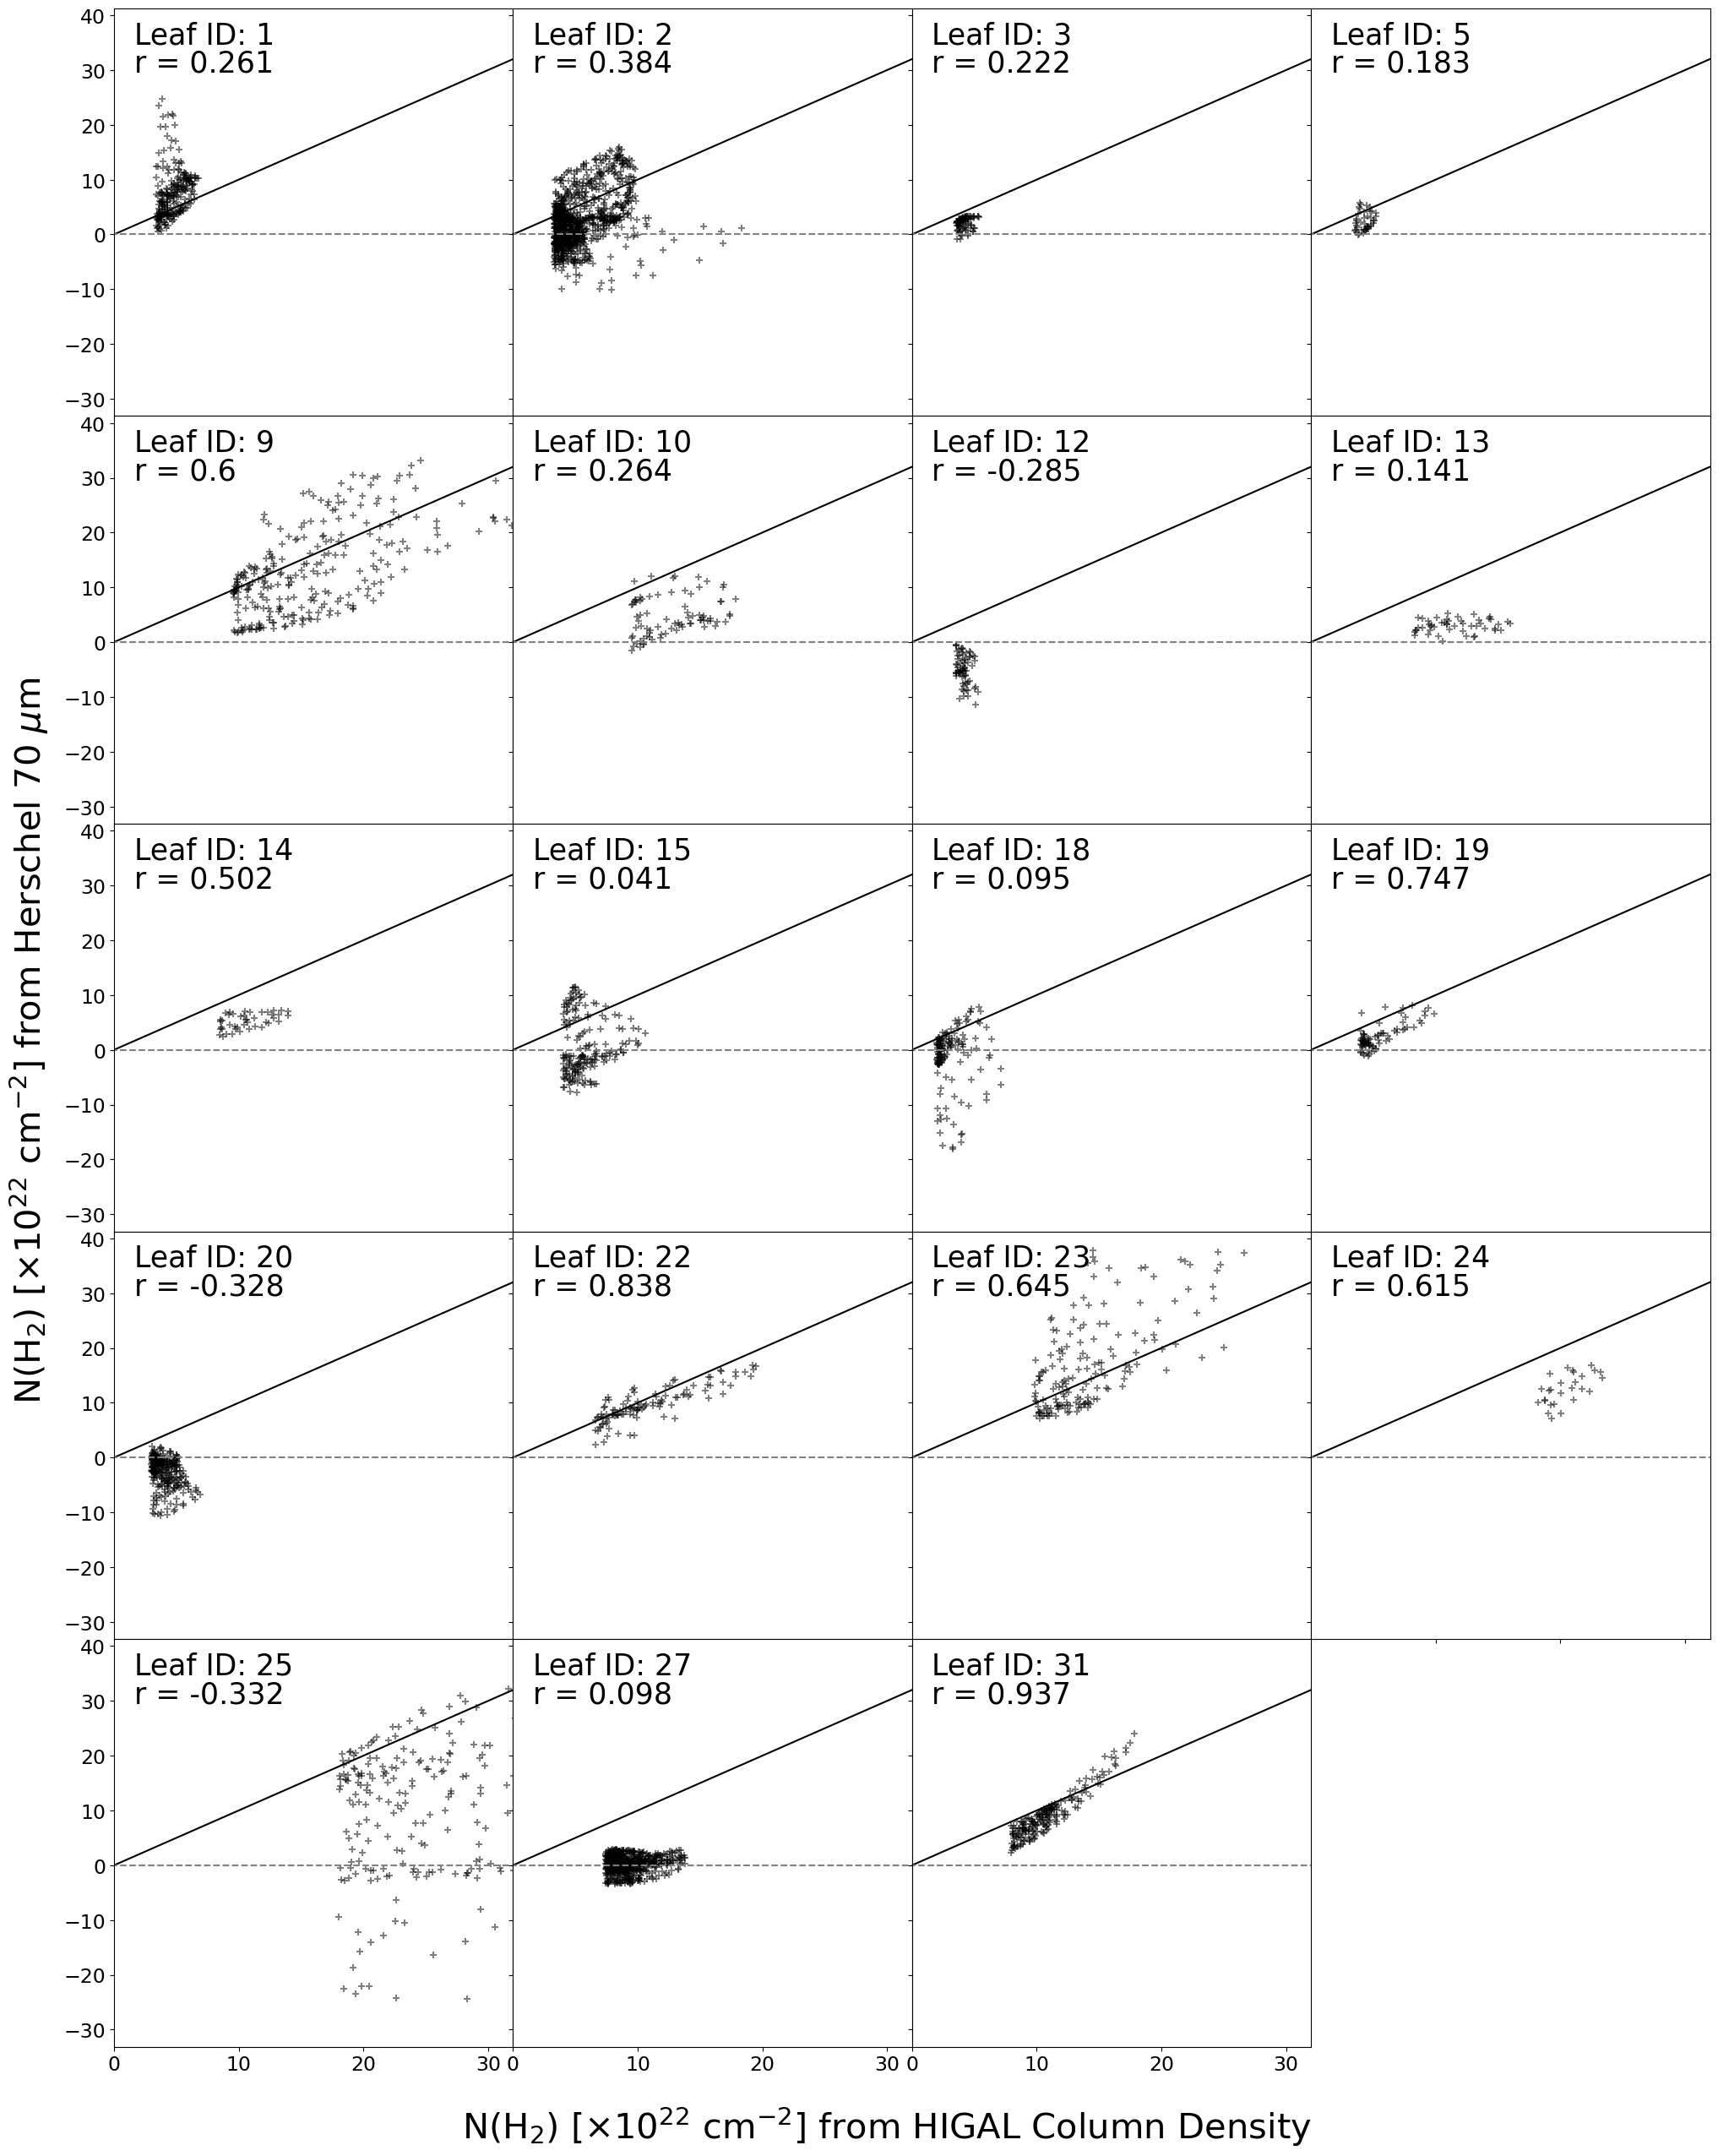

In [16]:
###ALL PLOTS####


corr_coeff_table = Table.read('./corr_coeff_table.tex')
#corr_coeff_id = cat_agg['index']
#corr_coeff_f05_all = cat_agg['r_p_max']
corr_coeff_cloud = corr_coeff_table['cloud list']

f_fore=0.50

fig, ax = plt.subplots(5, 4, sharex=True, sharey=True, figsize = (20,25))
fig.delaxes(ax[4,3])


plt.xlim(0,32)

#plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
#plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")

for i in range(5):
    for j in range(4):

        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i][j], plot_cloud_list[i][j], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i][j],plot_cloud_list[i][j])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,33)
        y = np.arange(-1,33)


        ax[i,j].scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))





        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 33, linestyle='--', color='gray')


        ax[i,j].text(.05, .97, 'Leaf ID: {}'.format(plot_cloud_id[i][j]), fontsize = 25, ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.05, .90, 'r = {}'.format(plot_cloud_r[i][j]), fontsize=25,  ha='left', va='top', transform=ax[i,j].transAxes)
        

        
fig.text(0.5, -0.02, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from HIGAL Column Density", ha='center', fontsize=30)
fig.text(-0.02, 0.5, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical', fontsize=30)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./paper_figs/Figs/70um_r_p_max_corr_coeff_single_components.pdf', bbox_inches='tight')

In [17]:
####SMALLER PANELED FIGURE FOR MAIN BODY!!!####



def plot_70_um_methods_panels(cloud):
    
    
    
    

    #example_8um=pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].data
    #wcs_8um = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_smoothed=pyfits.open('./Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_smoothed = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_70um=pyfits.open('./Cloud_masks/{}/{}_herschel70um_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_70um = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel70um_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_70um_masked=pyfits.open('./Cloud_masks/{}/{}_herschel70um_sources_to_nans_cutout_isolated.fits'.format(cloud, cloud))[0].data
    example_70um_ExtN=pyfits.open('./Cloud_masks/{}/{}_70umExtN_ffore0.50_tonans.fits'.format(cloud, cloud))[0].data
    example_70um_ExtN_conv_regrid = pyfits.open('./Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].data

    example_hershel = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_herschel = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    
    fxsz = 20
    xyrat = 2./8.
    fysz = fxsz * xyrat
    ds = 0.1
    fig = plt.figure( figsize=(15,4), dpi=300)
    gs = GridSpec(2,33)
    gs.update(left=ds, right=1-ds, bottom=ds, top=1-ds, hspace=0, wspace=0)

    wcs = wcs_70um

    axes1 = plt.subplot(gs[0:2, 0:7], projection=wcs)
    axes2 = plt.subplot(gs[0:2,8:15], projection=wcs)
    axes3 = plt.subplot(gs[0:2,16:23], projection=wcs)
    
    axes4 = plt.subplot(gs[0:2,26:])
    
    plt.rcParams.update({'font.size': 10})    

    
    
    
    mpl.rc('image', cmap='Blues_r')


    #match 70um and 70um masked colorscales 
    im_herschel = axes3.imshow(example_hershel/1e23, aspect='auto')
    vmin_hers, vmax_hers = im_herschel.get_clim()
    
    im_70um = axes1.imshow(example_70um/1e3, aspect='auto')
    
    
    im_70um_ExtN_conv_regrid = axes2.imshow(example_70um_ExtN_conv_regrid/1e23,vmin=vmin_hers, vmax=vmax_hers, aspect='auto')


    
    
    
    
    
    ###BEAUTIFY PLOTS####    

    for i in [axes2,axes3]:
            lon = i.coords['glon']
            lat = i.coords['glat']
            lon.set_ticks_visible(False)
            lon.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
            i.set_facecolor('grey')
            
            
            
    #ax[0,0] can keep labels and ticks, the rest dont need them

    lon = axes1.coords['glon']
    lat = axes1.coords['glat']
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    
    axes1.set_facecolor('gray')
    axes1.set_xlabel('Galactic Longitude', fontsize =20)
    axes1.set_ylabel('Galactic Latitude', fontsize =20)
    axes1.tick_params(labelsize=13)
    axes1.set_facecolor('grey')

    
    
   
    
    
    
    
    cb1 = fig.colorbar(im_70um, ax=axes1, location='top',pad=0.0)
    cb2 = fig.colorbar(im_70um_ExtN_conv_regrid, ax=axes2, location='top',pad=0.0)
    cb3 = fig.colorbar(im_herschel, ax=axes3, location='top',pad=0.0)

    
    cb1.set_label(label = r'[10$^{3}$ MJy/sr]', labelpad=5, x=0.5, rotation=0, fontsize = 15)
    cb2.set_label(label = r'[10$^{23}$ cm$^{-2}$]', labelpad=5, x=0.5, rotation=0, fontsize = 15)
    cb3.set_label(label = r'[10$^{23}$ cm$^{-2}$]', labelpad=5, x=0.5, rotation=0, fontsize = 15)

    
    from string import ascii_lowercase as alc

    lab_list=[axes1,axes2,axes3]
    for m in range(len(lab_list)):
        lab_list[m].text(0.07, 0.92,'({})'.format(alc[m]), ha='center', va='center', transform=lab_list[m].transAxes)
    
    
       
    axes1.text(0.77, 0.95,r'Herschel 70$\mu m$', ha='center', va='center', transform=axes1.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 10)  
    axes2.text(0.80, 0.92,"70$\mu m$ ExtN\nConv+Regrid", ha='center', va='center', transform=axes2.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 10)
    axes3.text(0.77, 0.95,r'Herschel N(H2)', ha='center', va='center', transform=axes3.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 10)

    
    

    
    
    ###Add on scatterplot example as 4th axis###
    
    
    
    f_fore=0.50



    regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud,cloud, f_fore)

    regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

    cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud,cloud, f_fore)
    cloud_hers_data = pyfits.open(cloud_hers)[0].data

    wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)





    x = np.arange(-1,33)
    y = np.arange(-1,33)


    axes4.scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
            marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))


    #make parasite axis for optical depth 
    xold = np.arange(0, 32, 2)
    xnew = tau_nu(xold,1.74)*1e22
    
    def forward(x):
        return np.interp(x, xold, xnew)


    def inverse(x):
        return np.interp(x, xnew, xold)
    par = axes4.secondary_xaxis('top', functions=(forward, inverse))
    par.set_xlabel(r"$\tau_{70\mu m}$", ha='center', fontsize =15, labelpad=10)
    


    axes4.plot(x,y, c='black')
    axes4.hlines(0,-1, 33, linestyle='--', color='gray')

    axes4.set_xlim(0,32)
    axes4.text(.05, .97, 'Leaf ID: {}'.format(plot_cloud_id[np.where(plot_cloud_list == cloud)][0]), ha='left', va='top', transform=axes4.transAxes)
    axes4.text(.05, .90, 'r = {}'.format(plot_cloud_r[np.where(plot_cloud_list == cloud)][0]), ha='left', va='top', transform=axes4.transAxes)
        

        
    axes4.set_xlabel(r"$N(H_{2})$ [$\times10^{22} cm^{-2}$]" + "\nfrom HIGAL Column Density", ha='center', fontsize =15)
    axes4.set_ylabel(r"$N(H_{2})$ [$\times10^{22} cm^{-2}$]" +"\nfrom Herschel 70 $\mu$m", va='center', rotation='vertical', labelpad=25, fontsize=15)


    

    
    #plt.tight_layout(w_pad = 0.2)
    
    plt.savefig('./paper_figs/Figs/{}_six_panel_less.png'.format(cloud),bbox_inches='tight')


    plt.show()



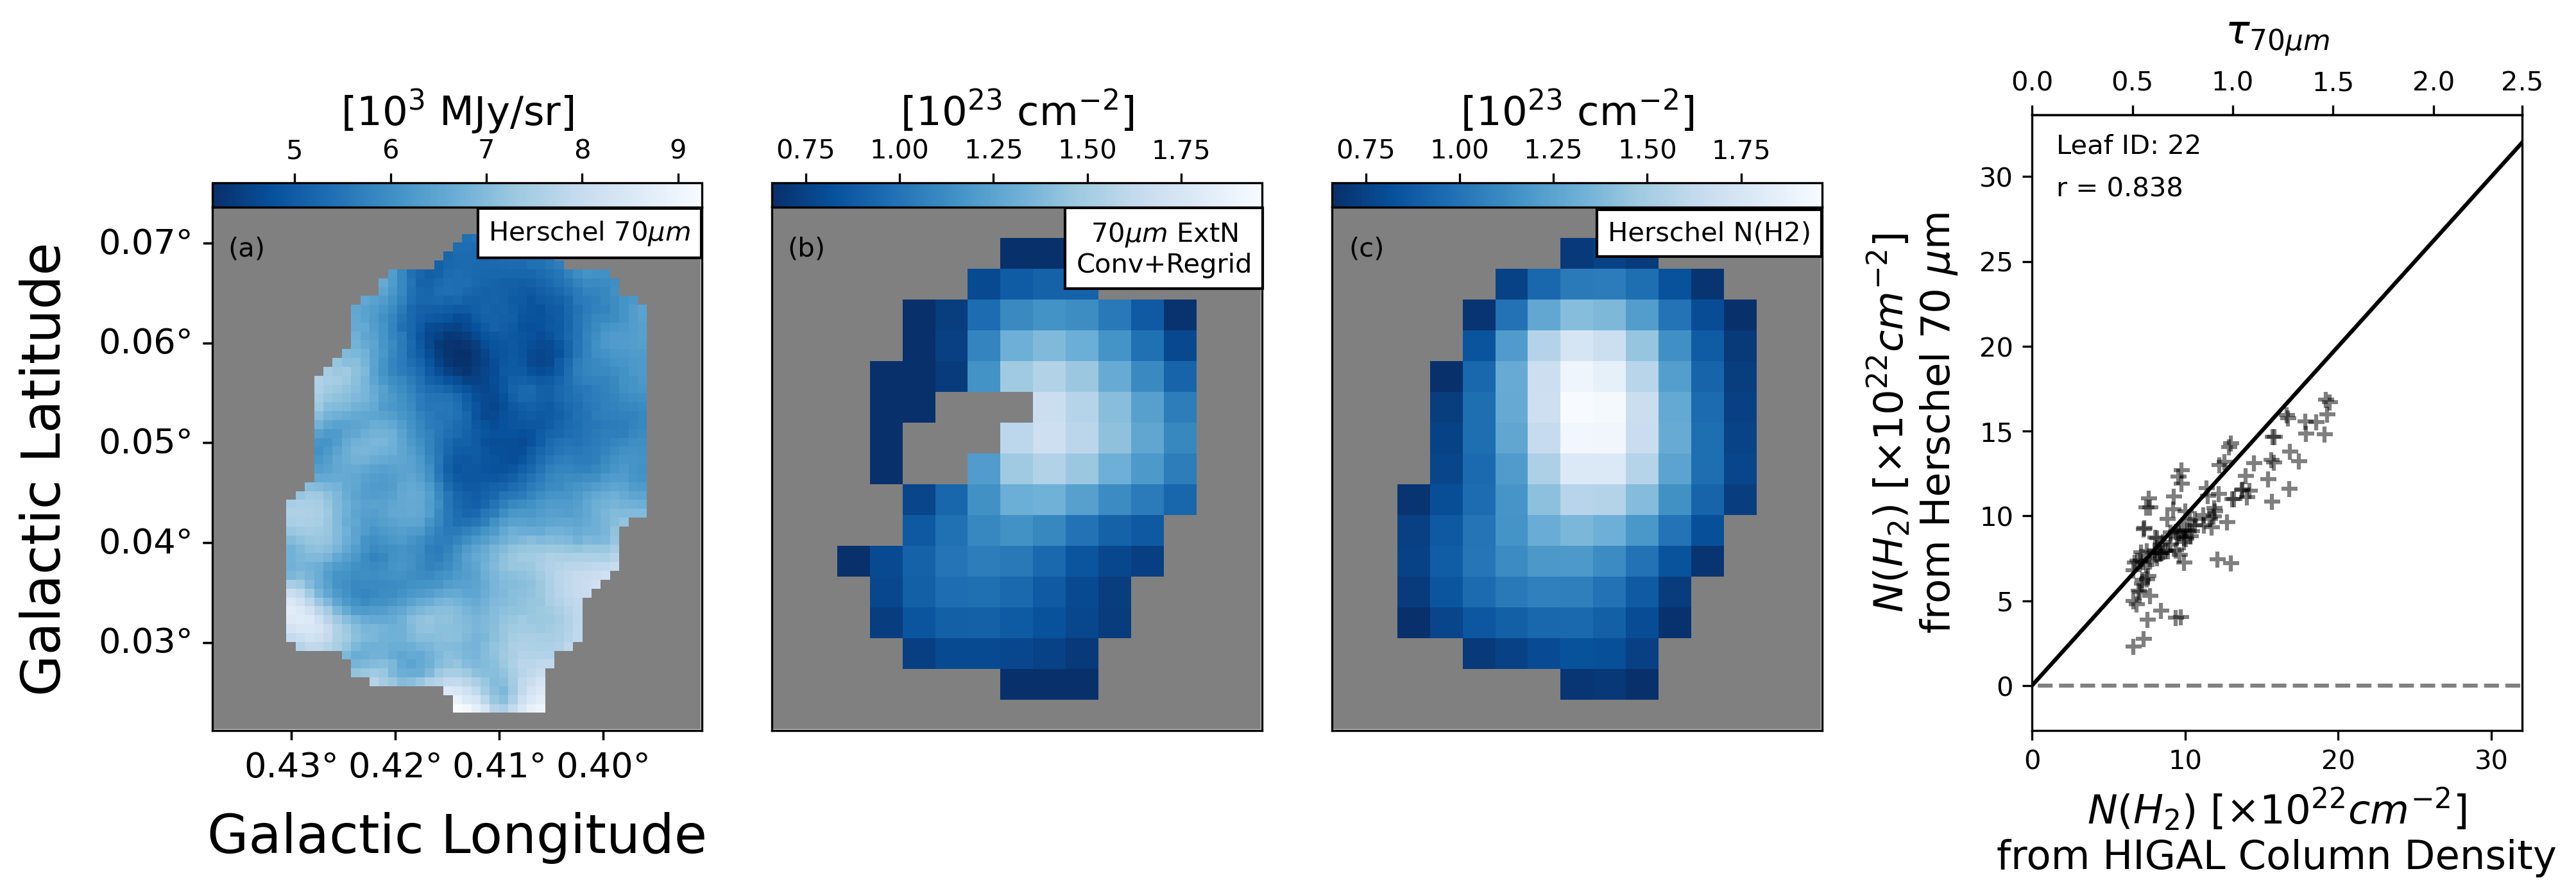

In [114]:
plot_70_um_methods_panels('G0.413+0.048')

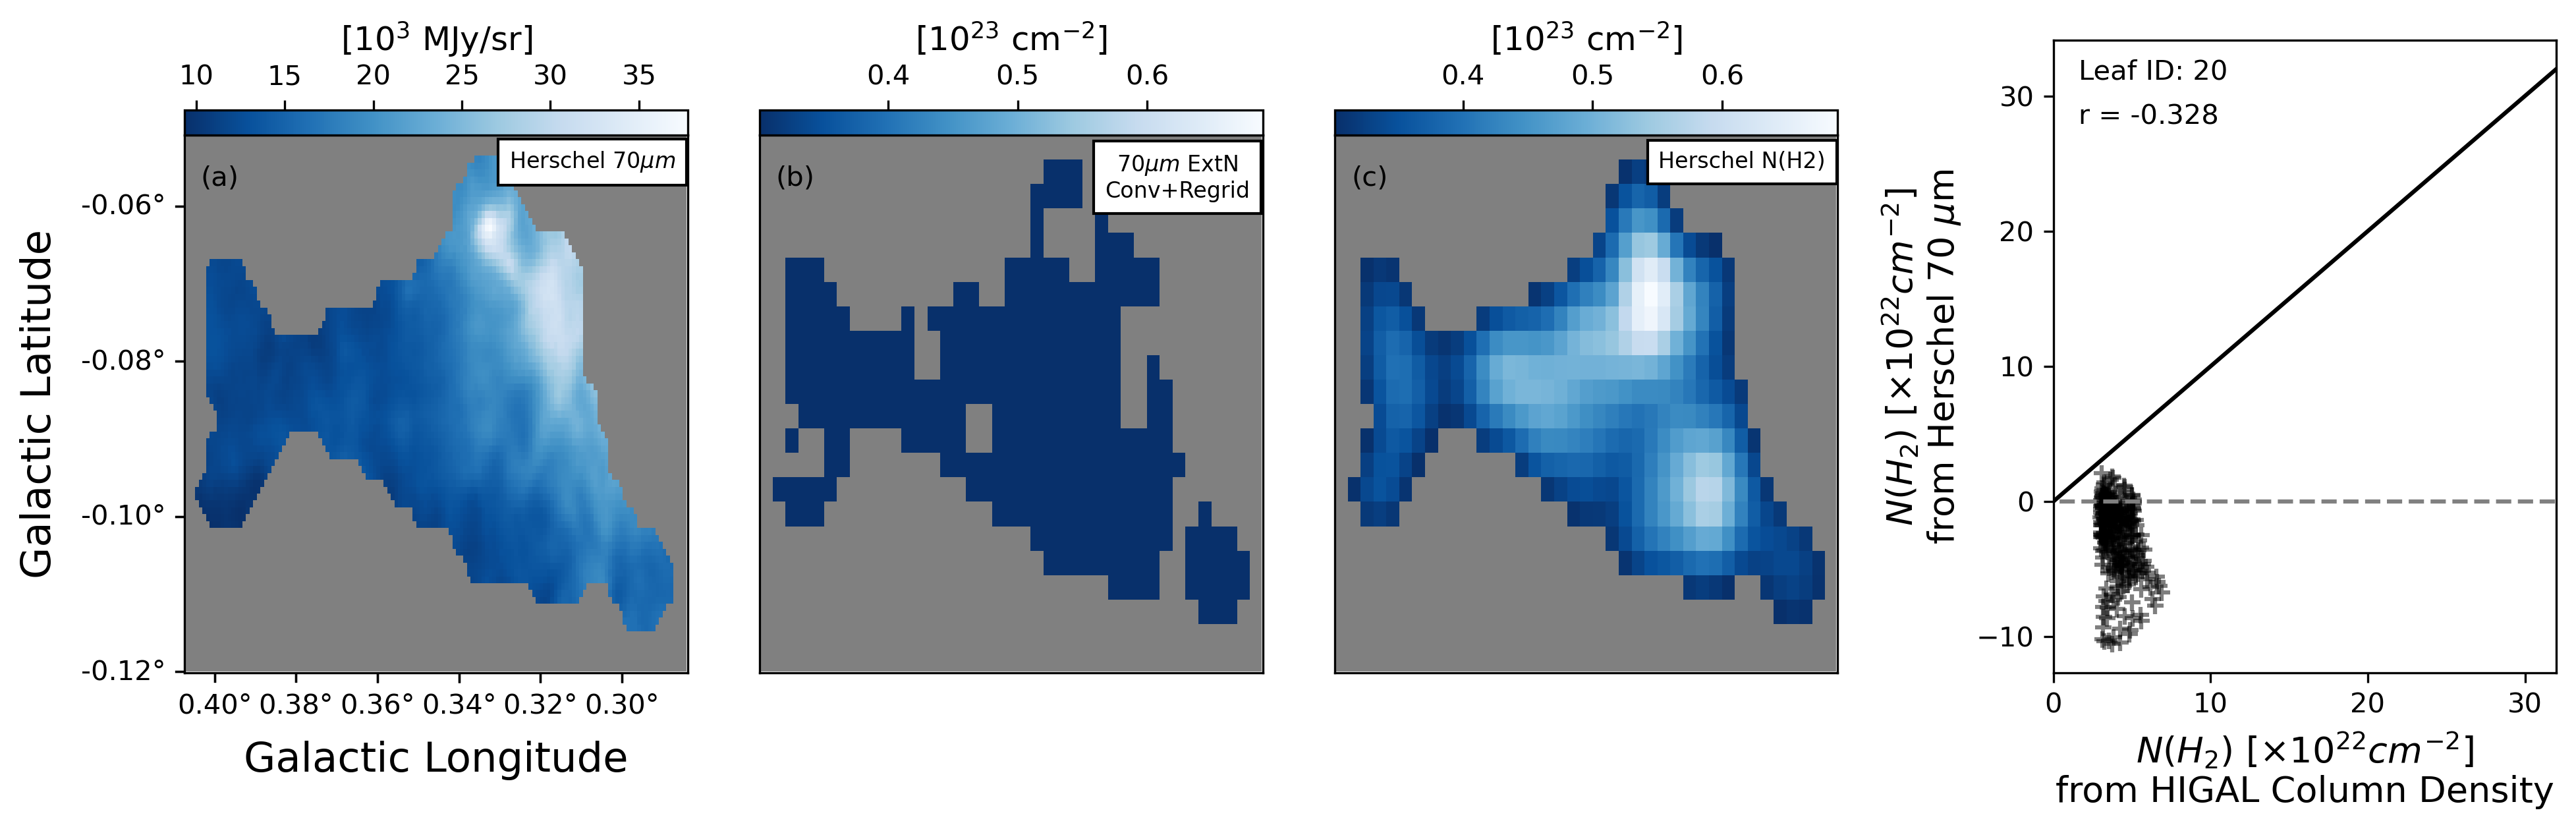

In [31]:
plot_70_um_methods_panels("G0.342-0.085")

# Foreground Fraction Calculations for clouds with approx distances

In [19]:
#Examples from Battersby 2010

gal_arr = np.arange(0,16,0.0001) #array from sun to 16kpc
ex_arr = np.arange(0,8.2-0.54,0.0001) 

gal_dist_ex = np.sum(disk_dist(gal_arr,1, 0.413))
ex_dist = np.sum(disk_dist(ex_arr,1,0.413))

print("ex f_fore = ", ex_dist/gal_dist_ex)



ex f_fore =  0.4005685118338707


In [20]:
#Make linspaces of d values from 0 to brick, and from 0 to 16kpc. 
#sum up along those arrays, then divide them for the foreground fraction

gal_arr = np.arange(0,16,0.001)
#brick_arr = np.arange(0,8.2-0.07,0.001)
brick_arr = np.arange(0,8.2-0.54,0.001)
sailfish_arr = np.arange(0,8.2+0.064,0.001)

gal_dist_brick = np.sum(disk_dist(gal_arr,1,0.225))
brick_dist = np.sum(disk_dist(brick_arr,1,0.225))

sailfish_dist = np.sum(disk_dist(sailfish_arr,1,0.342))
gal_dist_sailfish = np.sum(disk_dist(gal_arr,1,0.342))


print("brick f_fore = ", brick_dist/gal_dist_brick)
print("sailfish f_fore = ", sailfish_dist/gal_dist_sailfish)

brick f_fore =  0.400361816032603
sailfish f_fore =  0.4853270444965334


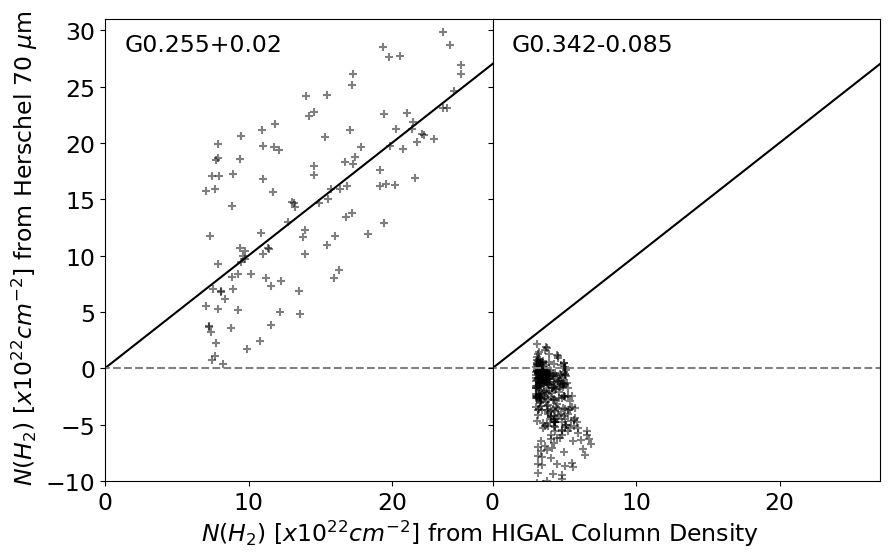

In [21]:
###Comparison plot of Brick and Sailfish###


plot_cloud_list = ["G0.255+0.02", "G0.342-0.085"]


f_fore=0.50

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (10,6))

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0,27)
plt.ylim(-10,31)

for i in range(2):

        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i], plot_cloud_list[i], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i],plot_cloud_list[i])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,30)
        y = np.arange(-1,30)


        ax[i].scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))





        ax[i].plot(x,y, c='black')
        ax[i].hlines(0,-1, 30, linestyle='--', color='gray')


        ax[i].text(.05, .97, '{}'.format(plot_cloud_list[i]), ha='left', va='top', transform=ax[i].transAxes)


fig.text(0.5, 0.01, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.03, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical')


plt.savefig('./paper_figs/Figs/70um_brick_sailfish_comparison.pdf')